In [90]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import pytz
import numpy as np

from models.gan_models import *
import yfinance as yf
import MetaTrader5 as mt5
import matplotlib.pyplot as plt

import os

In [92]:
data = pd.read_csv('xau_2021_H4.csv')

In [93]:
input_size = 1
hidden_size = 1024
seq_length = 50
num_layers = 10
batch_size = 32
num_epochs = 150
learning_rate = 0.3

# Initialize models
main_gen = MainGenerator(input_size, hidden_size, num_layers, 0.5, 1)
noise_gen = NoiseGenerator(input_size, 1024, 1, 0.4)
discriminator = Discriminator(input_size, hidden_size, 15, 0.4)

In [94]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [95]:
main_gen = torch.load('checkpoints/main_gen_xau.pth', map_location=torch.device(device))
noise_gen = torch.load('checkpoints/noise_gen_xau.pth', map_location=torch.device(device))
discriminator = torch.load('checkpoints/discriminator_xau.pth', map_location=torch.device(device))

In [96]:
main_gen.eval()
noise_gen.eval()
discriminator.eval()

Discriminator(
  (lstm): LSTM(1, 1024, num_layers=15, batch_first=True, dropout=0.4)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

In [97]:
actual1_data = data[:int(len(data)*0.9)]
actual2_data = data[int(len(data)*0.9):]

In [17]:
for idx in range(len(actual1_data)):
    price = torch.tensor(actual1_data.iloc[idx].close, dtype=torch.float).reshape(1,1)
    price = price.to(device)
    # Generate random noise inputs
    z1 = torch.rand([1])
    z1 = z1.to(device)
    #z2 = cauchy_dist.sample([1])
    # Generate fake data
    fake_main = main_gen(price)
    fake_noise = noise_gen(z1)
    fake_data = fake_main + fake_noise

    disc_out = discriminator(fake_data)
    log_disc_out = F.log_softmax(disc_out , dim=0)

In [98]:
prdictions_list = []
simulations_count = 10
sim_range = len(actual2_data)
for sim in range(simulations_count):
    predictions = []
    price = torch.tensor(actual1_data.iloc[-1].close, dtype=torch.float).reshape(1,1)
    generated = main_gen(price)
    #generated = torch.exp(generated)
    predictions.append(generated)
    for p_item in range(sim_range-1):
        generated = main_gen(predictions[-1])
        noise = noise_gen(torch.rand([1]))
        #generated = torch.exp(generated)
        #noise = torch.exp(noise)
        fake = generated + noise
        predictions.append(fake)
    for predi in range(len(predictions)):
        predictions[predi] = predictions[predi].item()
    prdictions_list.append(predictions)

In [99]:
import pickle


# Open a file in binary write mode
with open('prdictions_list.pickle', 'wb') as f:
    # Pickle the list
    pickle.dump(prdictions_list, f)

In [100]:
predictions_df = pd.DataFrame(prdictions_list).T

In [101]:
predictions_df

,0,1,2,3,4,5,6,7,8,9
0,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708,-0.449708
1,-0.848298,-0.848312,-0.848315,-0.848331,-0.848245,-0.848262,-0.848337,-0.848297,-0.848236,-0.848245
2,-0.848256,-0.848262,-0.848279,-0.848268,-0.848250,-0.848274,-0.848290,-0.848253,-0.848264,-0.848341
3,-0.848238,-0.848290,-0.848241,-0.848254,-0.848310,-0.848286,-0.848297,-0.848339,-0.848242,-0.848240
4,-0.848288,-0.848238,-0.848300,-0.848261,-0.848257,-0.848250,-0.848253,-0.848268,-0.848237,-0.848299
...,...,...,...,...,...,...,...,...,...,...
554,-0.848319,-0.848255,-0.848281,-0.848289,-0.848337,-0.848254,-0.848286,-0.848246,-0.848241,-0.848244
555,-0.848249,-0.848277,-0.848260,-0.848271,-0.848243,-0.848296,-0.848286,-0.848250,-0.848279,-0.848253
556,-0.848319,-0.848263,-0.848253,-0.848288,-0.848294,-0.848254,-0.848335,-0.848318,-0.848252,-0.848320
557,-0.848247,-0.848240,-0.848345,-0.848239,-0.848240,-0.848277,-0.848291,-0.848264,-0.848333,-0.848293


<Axes: >

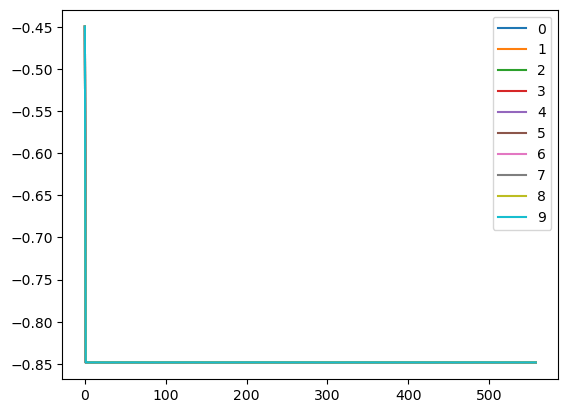

In [102]:
predictions_df.plot()

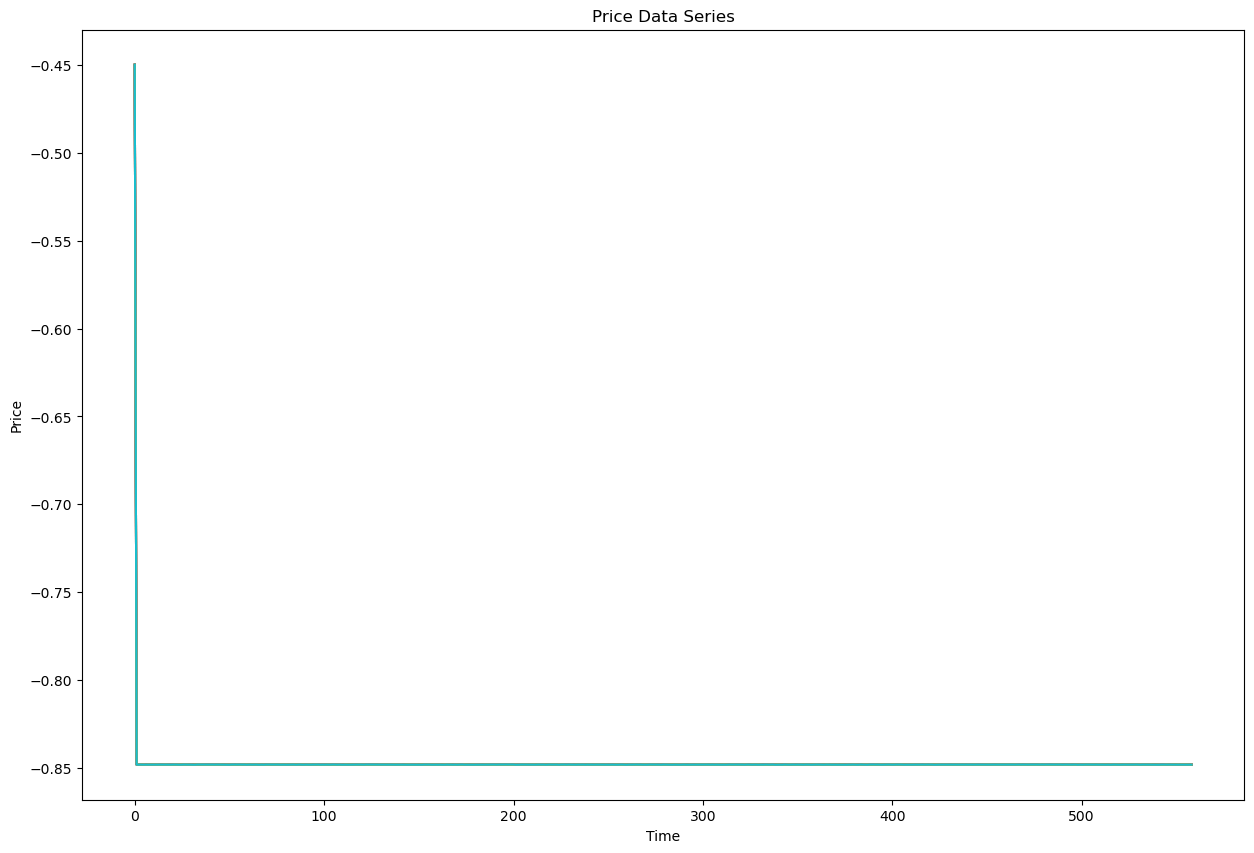

In [103]:
plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

for col in predictions_df.columns:
    plt.plot(predictions_df[col], label=col)  # Plot each column

plt.title('Price Data Series')
plt.xlabel('Time')
plt.ylabel('Price')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=2)  # Adjust legend position
plt.show()